In [1]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import re
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
nlp = spacy.load("en_core_web_sm")

# ICE

In [3]:
train_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/ice_train_data.csv", encoding='ISO-8859-1')
prediction_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/ice_test_data.csv", encoding='ISO-8859-1')

In [4]:
def preprocess_text(text):
    # Replace NaN values with empty strings
    text = str(text) if pd.notnull(text) else ''
    # Remove special characters and formatting using regular expressions
    text = re.sub(r'\n', ' ', text)  # Replace newlines with spaces
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # Remove special characters except spaces
    
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]
    
    # Process the filtered text with spaCy for POS tagging
    doc = nlp(" ".join(filtered_tokens))
    
    # Create a list of token information (word/POS_tag/POS)
    processed_tokens = [f"{token.text}/{token.tag_}/{token.pos_}" for token in doc]
    
    # Join the processed tokens back into a sentence
    processed_text = " ".join(processed_tokens)
    
    return processed_text

# Apply the preprocessing function to the 'Comment' column of your train dataset
train_data['Processed_comment'] = train_data['Comment'].apply(preprocess_text)

# Apply the preprocessing function to the 'Comment' column of your test dataset
prediction_data['Processed_comment'] = prediction_data['Comment'].apply(preprocess_text)

In [7]:
#train_data.info()

## Naive Bayes Model

In [10]:
# Convert the training text data to a numerical representation using CountVectorizer
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_data['Processed_comment'])  # Use 'Processed_comment' with a lowercase 'c'
y_train = train_data['Age_Group']

# Create and train a Multinomial Naive Bayes classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

with open('vectorizer.pkl', 'wb') as vectorizer_file:
    pickle.dump(vectorizer, vectorizer_file)
with open('naive_bayes_model.pkl', 'wb') as model_file:
    pickle.dump(clf, model_file)

with open('vectorizer.pkl', 'rb') as vectorizer_file:
    loaded_vectorizer = pickle.load(vectorizer_file)
with open('naive_bayes_model.pkl', 'rb') as model_file:
    loaded_clf = pickle.load(model_file)

# Convert the prediction text data to the same numerical representation
X_pred = loaded_vectorizer.transform(prediction_data['Processed_comment'])
predicted_ages = loaded_clf.predict(X_pred)
prediction_data['predicted_age'] = predicted_ages
prediction_data.to_csv('ICE_naive_bayes_predictions.csv', index=False)

In [12]:
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-validated accuracy scores:", scores)
print("Mean accuracy:", scores.mean())

Cross-validated accuracy scores: [0.22727273 0.36363636 0.28571429 0.33333333 0.38095238]
Mean accuracy: 0.3181818181818182


In [13]:
prediction_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/ICE_naive_bayes_predictions.csv", encoding='utf-8')

In [14]:
age_group_counts = prediction_data['predicted_age'].value_counts()
print("Age Group Counts:")
print(age_group_counts)

Age Group Counts:
20    30
40     4
30     2
Name: predicted_age, dtype: int64


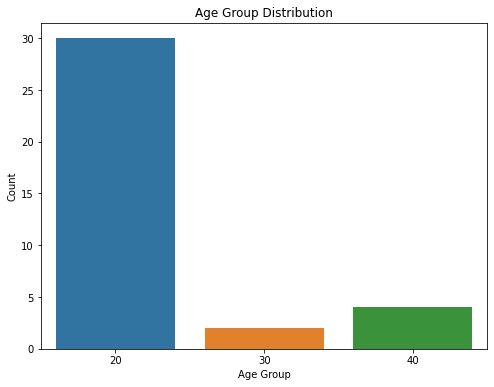

In [15]:
plt.figure(figsize=(8, 6))
sns.countplot(x='predicted_age', data=prediction_data)
plt.title("Age Group Distribution")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

The majority of individuals in the predicted age group for Maserati's ICE car models fall into the "20" category, with a count of 30. This indicates that the model predicts a strong interest among people in their twenties for Maserati's ICE cars.

## TD-IDF with Naive Bayes

In [16]:
# Vectorize the comments using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data['Processed_comment'])

# Train a Multinomial Naive Bayes classifier on the entire dataset
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_tfidf, train_data['Age_Group'])

# Vectorize the comments in the prediction dataset using the same TF-IDF vectorizer
X_pred_tfidf = tfidf_vectorizer.transform(prediction_data['Processed_comment'])

predicted_ages = naive_bayes_classifier.predict(X_pred_tfidf)
prediction_data['predicted_age'] = predicted_ages
prediction_data.to_csv('ICE_TDIDF_predicted_ages.csv', index=False)

In [19]:
cross_val_scores = cross_val_score(naive_bayes_classifier, X_train_tfidf, train_data['Age_Group'], cv=5)
print("Average cross-validation accuracy:", np.mean(cross_val_scores))

Average cross-validation accuracy: 0.3181818181818181


In [20]:
# Evaluate the classifier on the training data
y_pred = clf.predict(X_train)
print("Training accuracy:", accuracy_score(y_train, y_pred))
print(classification_report(y_train, y_pred))

Training accuracy: 0.9252336448598131
              precision    recall  f1-score   support

          10       1.00      0.88      0.93        24
          20       0.85      0.97      0.90        34
          30       1.00      0.87      0.93        23
          40       0.93      0.96      0.94        26

    accuracy                           0.93       107
   macro avg       0.94      0.92      0.93       107
weighted avg       0.93      0.93      0.93       107



In [21]:
prediction_data = pd.read_csv("C:/Users/user/Documents/Bayes/ARP/ARP Topic/Codes/Codes/ICE_TDIDF_predicted_ages.csv", encoding='utf-8')

In [22]:
age_group_counts = prediction_data['predicted_age'].value_counts()
print("Age Group Counts:")
print(age_group_counts)

Age Group Counts:
20    36
Name: predicted_age, dtype: int64


The Naive Bayes model assigns importance to different words or features in the text data. These important features may influence the TF-IDF model's term weighting. For example, words that are highly indicative of a specific age group according to the Naive Bayes model may receive higher TF-IDF scores in the TF-IDF model.

TD-IDF with Naive Bayes gave you a count of 36 for the age group 20 is likely due to overfitting.

It may have overly associated specific words or phrases with age group 20 during training. Consequently, when it evaluates a new comment, it quickly leans towards predicting age 20 if it spots any of these words or phrases, even if the comment should belong to a different age group.

## Logistic Regression - N-gram Vectorization

In [24]:
# Convert the training text data to a numerical representation using CountVectorizer
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
X_train = vectorizer.fit_transform(train_data['Processed_comment'])
y_train = train_data['Age_Group']

# Create and train a Logistic Regression classifier
clf = LogisticRegression(max_iter=1000, C=1.0, penalty='l2', solver='liblinear')
clf.fit(X_train, y_train)

X_pred = vectorizer.transform(prediction_data['Processed_comment'])
predicted_ages = clf.predict(X_pred)

In [25]:
cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Average cross-validation accuracy:", np.mean(cross_val_scores))

Average cross-validation accuracy: 0.24415584415584415
